Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 0.18606770532478006
Overall Average MSE: 4.385033561131903


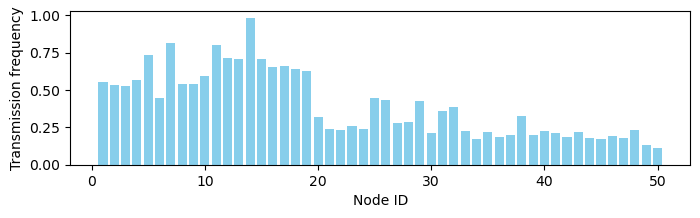

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
#pivot_df = pivot_df.head(2000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 2                         # Sensitivity threshold for event detection
theta = 2                        # Threshold for significant change
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
rho = 1                            # Probability of successful transmission for Whittle index

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

def calculate_whittle_index(j, rho):
    return j * (j + 1) * rho / 2 

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()  # Initialize previously_polled_nodes
    mse_values = {f'mote{i}': [] for i in range(1, 51)}  # To track MSE values for each node

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Calculate the combined metric for each node
        combined_metrics = {}
        for mote in last_update_times:
            j = current_time_step - last_update_times[mote]
            whittle_index = calculate_whittle_index(j, rho)
            delta_t = max(current_time_step - last_update_times[mote], 1)
            predicted_state = predict_node_state(state_estimates[mote], delta_t)
            predicted_value = H @ predicted_state
            current_value = row[mote]
            distance_metric = np.abs(predicted_value - current_value)
            combined_metrics[mote] = whittle_index * distance_metric

        # Select top M nodes based on the combined metric
        nodes_by_combined_metric = sorted(combined_metrics.keys(), key=lambda mote: combined_metrics[mote], reverse=True)
        top_m_nodes = nodes_by_combined_metric[:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)
            mse_values[mote].append(diff**2)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 1000:
                transmission_events_1[mote].append(current_time_step)
            elif 1000 <= current_time_step < 2000:
                transmission_events_2[mote].append(current_time_step)

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Pad the MSE lists to the same length
    max_length = max(len(v) for v in mse_values.values())
    for key in mse_values:
        mse_values[key].extend([None] * (max_length - len(mse_values[key])))

    mse_df = pd.DataFrame(mse_values)

    return valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
mse_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    mse_df_list.append(mse_df)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Calculate the overall average MSE
overall_mse = mse_df_list[0].mean().mean()
print(f"Overall Average MSE: {overall_mse}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()


Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 1.4902028106720964
Overall Average MSE: 4.960711019493125


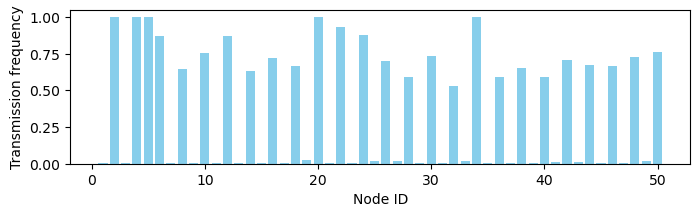

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('simulated_sensor_data.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 2                           # Sensitivity threshold for event detection
theta = 2                             # Threshold for significant change
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
rho = 1                               # Probability of successful transmission for Whittle index
pdr = 1                             # Probability of transmission failure

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

# Initialize value function
V_mi = {f'mote{i}': 0 for i in range(1, 51)}

def calculate_Q_value(mote, action, current_time_step, R_s, delta_t, d):
    if action == 0:
        # No transmit
        Q_value = R_s + V_mi[mote]
    else:
        # Transmit
        V_mi_fail = d * (delta_t + 1) + V_mi[mote]  # Value when transmission fails
        V_mi_success = 0  # Success leads to a reset state
        Q_value = -theta + R_s + (1 - pdr) * V_mi_success + pdr * V_mi_fail
    return Q_value

def update_value_function(row):
    for mote in V_mi:
        delta_t = 1  # Assuming 1 for simplicity
        R_s = delta_t  # Reward is the change in time

        # Calculate the predicted measurement
        previous_state = state_estimates[mote]
        predicted_measurement = H @ predict_node_state(previous_state, delta_t)

        # Get the actual measured value
        measured_value = row[mote]

        # Calculate the distance metric d
        d = abs(predicted_measurement - measured_value)[0]

        Q_0 = calculate_Q_value(mote, 0, 0, R_s, delta_t, d)
        Q_1 = calculate_Q_value(mote, 1, 0, R_s, delta_t, d)
        V_mi[mote] = max(Q_0, Q_1)

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    mse_values = {f'mote{i}': [] for i in range(1, 51)}  # To track MSE values for each node

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Update the value function for all nodes
        update_value_function(row)

        # Select top M nodes based on the value function
        nodes_by_value = sorted(V_mi.keys(), key=lambda mote: V_mi[mote], reverse=True)
        top_m_nodes = nodes_by_value[:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)
            mse_values[mote].append(diff**2)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'time_elapsed': j
            })



        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Pad the MSE lists to the same length
    max_length = max(len(v) for v in mse_values.values())
    for key in mse_values:
        mse_values[key].extend([None] * (max_length - len(mse_values[key])))

    mse_df = pd.DataFrame(mse_values)

    return valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
mse_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    mse_df_list.append(mse_df)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Calculate the overall average MSE
overall_mse = mse_df_list[0].mean().mean()
print(f"Overall Average MSE: {overall_mse}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()


Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 0.14974998666383021
Overall Average MSE: 4.687744197062526


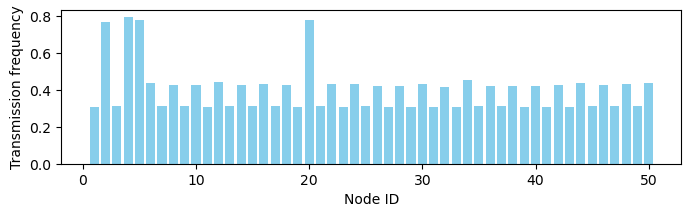

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('simulated_sensor_data.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 2                           # Sensitivity threshold for event detection
theta = 2                             # Threshold for significant change
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 1                             # Probability of transmission failure
gamma = 0.9                           # Discount factor for future rewards

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

# Initialize value function
V_mi = {f'mote{i}': 0 for i in range(1, 51)}

def calculate_Q_value(mote, R_s, delta_t, d, m_i):
    # Calculate Q-value for the pull action (a = 1)
    
    V_mi_success = d * (delta_t + 1)  # Value when transmission fails
    V_mi_fail = -1  # no value in transmitting.
    Q_value = -m_i + R_s + gamma * ((pdr * V_mi_success + (1 - pdr) * V_mi_fail ) / 2)
    return Q_value

def update_value_function(row, current_time_step):
    for mote in V_mi:
        delta_t = current_time_step - last_update_times[mote]  # Calculate delta_t as the change in time
        R_s = delta_t  # Reward is the change in time

        # Calculate the predicted measurement
        previous_state = state_estimates[mote]
        predicted_measurement = H @ predict_node_state(previous_state, delta_t)

        # Get the actual measured value
        measured_value = row[mote]

        # Calculate the distance metric d
        d = abs(predicted_measurement - measured_value)[0]

        # Calculate Q value with the specified penalty
        Q_1 = calculate_Q_value(mote, R_s, delta_t, d, theta)

        # Update value function based on the Q value
        V_mi[mote] = Q_1

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    mse_values = {f'mote{i}': [] for i in range(1, 51)}  # To track MSE values for each node

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Update the value function for all nodes
        update_value_function(row, current_time_step)

        # Select top M nodes based on the value function where Qmi(s, 1) > -theta
        nodes_by_value = sorted(V_mi.keys(), key=lambda mote: V_mi[mote], reverse=True)
        top_m_nodes = [mote for mote in nodes_by_value if V_mi[mote] > -theta][:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)
            mse_values[mote].append(diff**2)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 1000:
                transmission_events_1[mote].append(current_time_step)
            elif 1000 <= current_time_step < 2000:
                transmission_events_2[mote].append(current_time_step)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Pad the MSE lists to the same length
    max_length = max(len(v) for v in mse_values.values())
    for key in mse_values:
        mse_values[key].extend([None] * (max_length - len(mse_values[key])))

    mse_df = pd.DataFrame(mse_values)

    return valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
mse_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    mse_df_list.append(mse_df)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Calculate the overall average MSE
overall_mse = mse_df_list[0].mean().mean()
print(f"Overall Average MSE: {overall_mse}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()


Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 0.6932293845902985
Overall Average MSE: 7.553419131056426


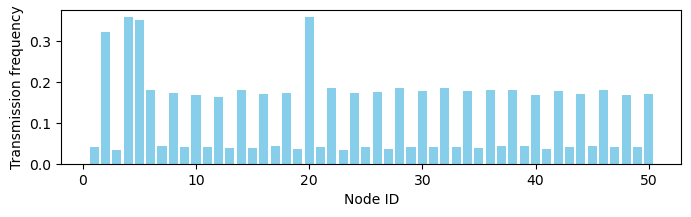

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('simulated_sensor_data.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 2                           # Sensitivity threshold for event detection
m_i = 2                               # Threshold for penalizing sending
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.1                             # Probability of transmission failure
gamma = 0.9                           # Discount factor for future rewards

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

# Initialize value function
V_mi = {f'mote{i}': 0 for i in range(1, 51)}

def calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i):
    # Calculate R_s as the age of incorrect information
    R_s = delta_t * d

    # Calculate V_mi_fail as the expected value when transmission fails
    V_mi_fail = d_t_plus_1 * (delta_t + 1)

    # V_mi_success remains 0 because success leads to a reset state
    V_mi_success = 0

    # Calculate Q-value for the pull action (a = 1)
    Q_value = -m_i + R_s + gamma * ((1 - pdr) * V_mi_success - pdr * V_mi_fail)
    return Q_value

def update_value_function(row, current_time_step):
    for mote in V_mi:
        delta_t = current_time_step - last_update_times[mote]  # Calculate delta_t as the change in time

        # Access the previous state estimate
        previous_state = state_estimates[mote]

        # Predict the next state based on the previous state and delta_t
        predicted_state = predict_node_state(previous_state, delta_t)

        # Predict the measurement from the predicted state
        predicted_measurement = H @ predicted_state

        # Predict the future state and measurement for t + delta_t + 1
        future_state = predict_node_state(predicted_state, delta_t + 1)
        future_predicted_measurement = H @ future_state

        # Calculate the distance metric d (difference between predicted measurement and previous state)
        d = abs(predicted_measurement[0, 0] - previous_state[0, 0])

        # Calculate d_t_plus_1 (difference between future predicted measurement and current predicted measurement)
        d_t_plus_1 = abs(future_predicted_measurement[0, 0] - predicted_measurement[0, 0])

        # Calculate Q value with the specified penalty
        Q_1 = calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i)

        # Update value function based on the Q value
        V_mi[mote] = Q_1

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    mse_values = {f'mote{i}': [] for i in range(1, 51)}  # To track MSE values for each node

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Update the value function for all nodes
        update_value_function(row, current_time_step)

        # Select top M nodes based on the value function where Qmi(s, 1) > 0
        nodes_by_value = sorted(V_mi.keys(), key=lambda mote: V_mi[mote], reverse=True)
        top_m_nodes = [mote for mote in nodes_by_value if V_mi[mote] > 0][:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[row[mote]]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - row[mote])
            mse_values[mote].append(diff**2)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': row[mote],
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 1000:
                transmission_events_1[mote].append(current_time_step)
            elif 1000 <= current_time_step < 2000:
                transmission_events_2[mote].append(current_time_step)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Pad the MSE lists to the same length
    max_length = max(len(v) for v in mse_values.values())
    for key in mse_values:
        mse_values[key].extend([None] * (max_length - len(mse_values[key])))

    mse_df = pd.DataFrame(mse_values)

    return valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
mse_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    mse_df_list.append(mse_df)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Calculate the overall average MSE
overall_mse = mse_df_list[0].mean().mean()
print(f"Overall Average MSE: {overall_mse}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()


Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 1.337229148995386
Overall Average MSE: 4.395692271982461


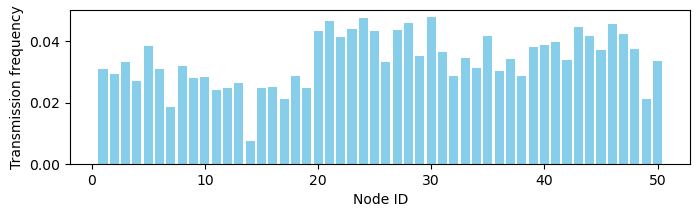

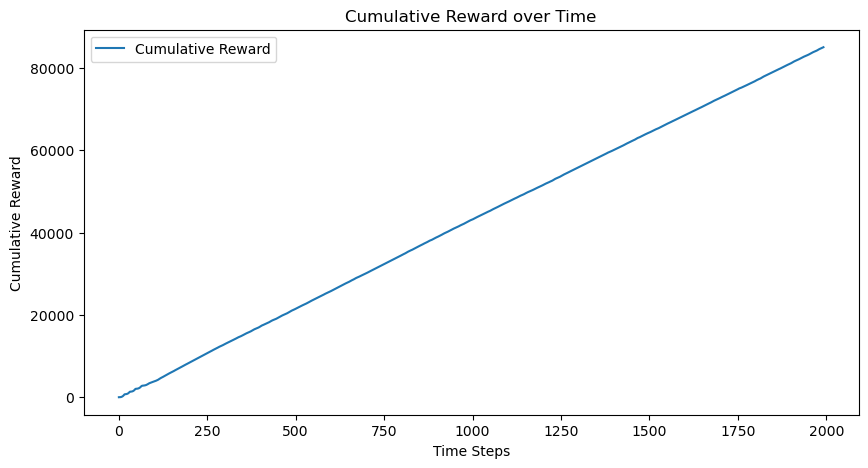

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 2                           # Sensitivity threshold for event detection
m_i = 2                               # Threshold for penalizing sending
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.1                             # Probability of transmission failure
gamma = 0.9                           # Discount factor for future rewards

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

# Initialize value function
V_mi = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize cumulative reward tracker
cumulative_reward = []

def calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i):
    # Calculate R_s as the age of incorrect information
    R_s = delta_t * d

    # Calculate V_mi_fail as the expected value when transmission fails
    V_mi_fail = d_t_plus_1 * (delta_t + 1)

    # V_mi_success remains 0 because success leads to a reset state
    V_mi_success = 0

    # Calculate Q-value for the pull action (a = 1)
    Q_value = -m_i + R_s + gamma * ((1 - pdr) * V_mi_success - pdr * V_mi_fail)
    return Q_value, R_s

def update_value_function(row, current_time_step):
    total_R_s = 0  # Initialize total reward for this time step
    for mote in V_mi:
        delta_t = current_time_step - last_update_times[mote]  # Calculate delta_t as the change in time

        # Access the previous state estimate
        previous_state = state_estimates[mote]

        # Predict the next state based on the previous state and delta_t
        predicted_state = predict_node_state(previous_state, delta_t)

        # Predict the measurement from the predicted state
        predicted_measurement = H @ predicted_state

        # Predict the future state and measurement for t + delta_t + 1
        future_state = predict_node_state(predicted_state, delta_t + 1)
        future_predicted_measurement = H @ future_state

        # Calculate the distance metric d (difference between predicted measurement and previous state)
        d = abs(predicted_measurement[0, 0] - previous_state[0, 0])

        # Calculate d_t_plus_1 (difference between future predicted measurement and current predicted measurement)
        d_t_plus_1 = abs(future_predicted_measurement[0, 0] - predicted_measurement[0, 0])

        # Calculate Q value with the specified penalty and obtain the reward
        Q_1, R_s = calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i)

        # Update value function based on the Q value
        V_mi[mote] = Q_1

        # Accumulate the reward for this time step
        total_R_s += R_s

    # Append the total reward for this time step to the cumulative reward tracker
    cumulative_reward.append(total_R_s)

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    mse_values = {f'mote{i}': [] for i in range(1, 51)}  # To track MSE values for each node

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Update the value function for all nodes
        update_value_function(idx, current_time_step)

        # Select top M nodes based on the value function where Qmi(s, 1) > 0
        nodes_by_value = sorted(V_mi.keys(), key=lambda mote: V_mi[mote], reverse=True)
        top_m_nodes = [mote for mote in nodes_by_value if V_mi[mote] > 0][:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[row[mote]]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - row[mote])
            mse_values[mote].append(diff**2)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': row[mote],
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 1000:
                transmission_events_1[mote].append(current_time_step)
            elif 1000 <= current_time_step < 2000:
                transmission_events_2[mote].append(current_time_step)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Pad the MSE lists to the same length
    max_length = max(len(v) for v in mse_values.values())
    for key in mse_values:
        mse_values[key].extend([None] * (max_length - len(mse_values[key])))

    mse_df = pd.DataFrame(mse_values)

    return valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
mse_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    mse_df_list.append(mse_df)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Calculate the overall average MSE
overall_mse = mse_df_list[0].mean().mean()
print(f"Overall Average MSE: {overall_mse}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()

# Plot cumulative reward over time
cumulative_reward_array = np.cumsum(cumulative_reward)
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_reward_array)), cumulative_reward_array, label='Cumulative Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time')
plt.legend()
plt.show()



In [17]:
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
len(pivot_df)

55805

Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 1.337229148995386
Overall Average MSE: 4.395692271982461


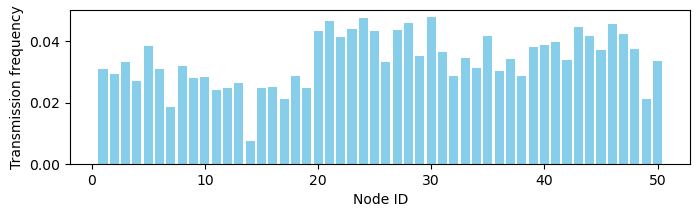

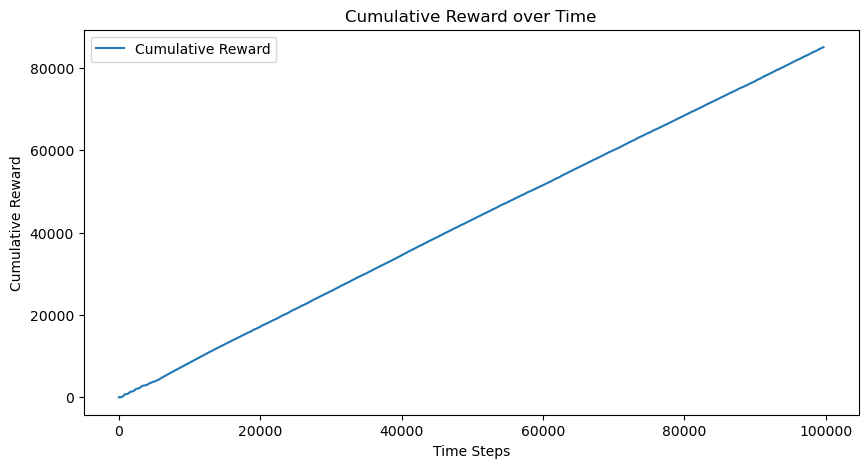

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 2                           # Sensitivity threshold for event detection
m_i = 2                               # Threshold for penalizing sending
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.1                             # Probability of transmission failure
gamma = 0.9                           # Discount factor for future rewards

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

# Initialize value function
V_mi = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize cumulative reward tracker
cumulative_reward = []

def calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i):
    # Calculate R_s as the age of incorrect information
    R_s = delta_t * d

    # Calculate V_mi_fail as the expected value when transmission fails
    V_mi_fail = d_t_plus_1 * (delta_t + 1)

    # V_mi_success remains 0 because success leads to a reset state
    V_mi_success = 0

    # Calculate Q-value for the pull action (a = 1)
    Q_value = -m_i + R_s + gamma * ((1 - pdr) * V_mi_success - pdr * V_mi_fail)
    return Q_value, R_s

def update_value_function(row, current_time_step):
    for mote in V_mi:
        delta_t = current_time_step - last_update_times[mote]  # Calculate delta_t as the change in time

        # Access the previous state estimate
        previous_state = state_estimates[mote]

        # Predict the next state based on the previous state and delta_t
        predicted_state = predict_node_state(previous_state, delta_t)

        # Predict the measurement from the predicted state
        predicted_measurement = H @ predicted_state

        # Predict the future state and measurement for t + delta_t + 1
        future_state = predict_node_state(predicted_state, delta_t + 1)
        future_predicted_measurement = H @ future_state

        # Calculate the distance metric d (difference between predicted measurement and previous state)
        d = abs(predicted_measurement[0, 0] - previous_state[0, 0])

        # Calculate d_t_plus_1 (difference between future predicted measurement and current predicted measurement)
        d_t_plus_1 = abs(future_predicted_measurement[0, 0] - predicted_measurement[0, 0])

        # Calculate Q value with the specified penalty and obtain the reward
        Q_1, R_s = calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i)

        # Update value function based on the Q value
        V_mi[mote] = Q_1

        # Append the reward for this time step to the cumulative reward tracker
        cumulative_reward.append(R_s)

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    mse_values = {f'mote{i}': [] for i in range(1, 51)}  # To track MSE values for each node

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Update the value function for all nodes
        update_value_function(row, current_time_step)

        # Select top M nodes based on the value function where Qmi(s, 1) > 0
        nodes_by_value = sorted(V_mi.keys(), key=lambda mote: V_mi[mote], reverse=True)
        top_m_nodes = [mote for mote in nodes_by_value if V_mi[mote] > 0][:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[row[mote]]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - row[mote])
            mse_values[mote].append(diff**2)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': row[mote],
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 1000:
                transmission_events_1[mote].append(current_time_step)
            elif 1000 <= current_time_step < 2000:
                transmission_events_2[mote].append(current_time_step)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Pad the MSE lists to the same length
    max_length = max(len(v) for v in mse_values.values())
    for key in mse_values:
        mse_values[key].extend([None] * (max_length - len(mse_values[key])))

    mse_df = pd.DataFrame(mse_values)

    return valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
mse_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    mse_df_list.append(mse_df)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Calculate the overall average MSE
overall_mse = mse_df_list[0].mean().mean()
print(f"Overall Average MSE: {overall_mse}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()

# Plot cumulative reward over time
cumulative_reward_array = np.cumsum(cumulative_reward)
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_reward_array)), cumulative_reward_array, label='Cumulative Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time')
plt.legend()
plt.show()


Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 0.6963976954202826
Overall Average MSE: 7.566149329921953


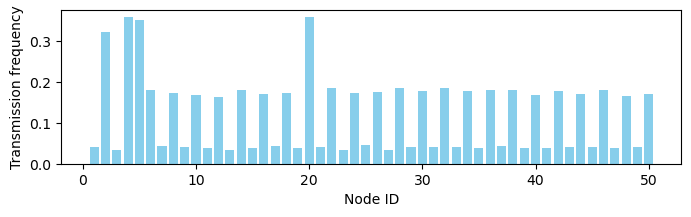

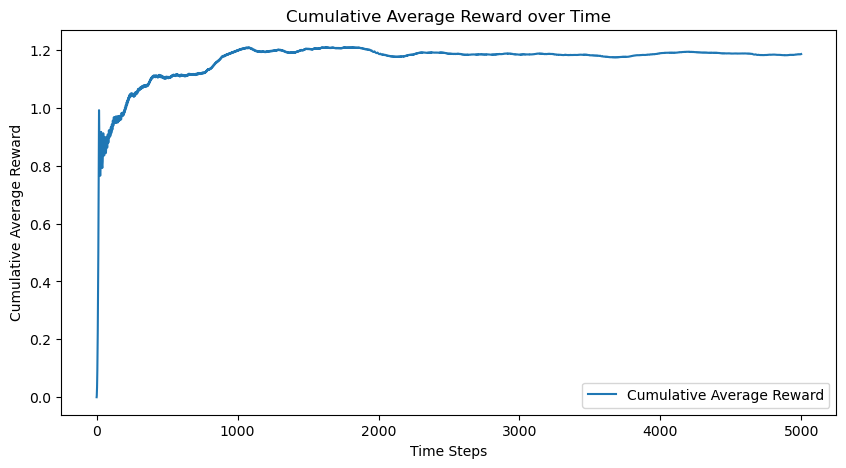

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('simulated_sensor_data.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 2                           # Sensitivity threshold for event detection
m_i = 2                               # Threshold for penalizing sending
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 5000            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.1                             # Probability of transmission failure
gamma = 0.9                           # Discount factor for future rewards

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

# Initialize value function
V_mi = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize cumulative reward tracker
cumulative_reward = []

def calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i):
    # Calculate R_s as the age of incorrect information
    R_s = delta_t * d

    # Calculate V_mi_fail as the expected value when transmission fails
    V_mi_fail = d_t_plus_1 * (delta_t + 1)

    # V_mi_success remains 0 because success leads to a reset state
    V_mi_success = 0

    # Calculate Q-value for the pull action (a = 1)
    Q_value = -m_i + R_s + gamma * ((1 - pdr) * V_mi_success - pdr * V_mi_fail)
    return Q_value, R_s

def update_value_function(row, current_time_step):
    total_R_s = 0
    for mote in V_mi:
        delta_t = current_time_step - last_update_times[mote]  # Calculate delta_t as the change in time

        # Access the previous state estimate
        previous_state = state_estimates[mote]

        # Predict the next state based on the previous state and delta_t
        predicted_state = predict_node_state(previous_state, delta_t)

        # Predict the measurement from the predicted state
        predicted_measurement = H @ predicted_state

        # Predict the future state and measurement for t + delta_t + 1
        future_state = predict_node_state(predicted_state, delta_t + 1)
        future_predicted_measurement = H @ future_state

        # Calculate the distance metric d (difference between predicted measurement and previous state)
        d = abs(predicted_measurement[0, 0] - previous_state[0, 0])

        # Calculate d_t_plus_1 (difference between future predicted measurement and current predicted measurement)
        d_t_plus_1 = abs(future_predicted_measurement[0, 0] - predicted_measurement[0, 0])

        # Calculate Q value with the specified penalty and obtain the reward
        Q_1, R_s = calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i)

        # Update value function based on the Q value
        V_mi[mote] = Q_1

        total_R_s += R_s

        # Append the reward for this time step to the cumulative reward tracker
    cumulative_reward.append(R_s)

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    mse_values = {f'mote{i}': [] for i in range(1, 51)}  # To track MSE values for each node

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Update the value function for all nodes
        update_value_function(row, current_time_step)

        # Select top M nodes based on the value function where Qmi(s, 1) > 0
        nodes_by_value = sorted(V_mi.keys(), key=lambda mote: V_mi[mote], reverse=True)
        top_m_nodes = [mote for mote in nodes_by_value if V_mi[mote] > 0][:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[row[mote]]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - row[mote])
            mse_values[mote].append(diff**2)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': row[mote],
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 1000:
                transmission_events_1[mote].append(current_time_step)
            elif 1000 <= current_time_step < 2000:
                transmission_events_2[mote].append(current_time_step)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Pad the MSE lists to the same length
    max_length = max(len(v) for v in mse_values.values())
    for key in mse_values:
        mse_values[key].extend([None] * (max_length - len(mse_values[key])))

    mse_df = pd.DataFrame(mse_values)

    return valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
mse_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    mse_df_list.append(mse_df)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Calculate the overall average MSE
overall_mse = mse_df_list[0].mean().mean()
print(f"Overall Average MSE: {overall_mse}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()

# Calculate cumulative reward and cumulative average reward
cumulative_reward_array = np.cumsum(cumulative_reward)
cumulative_average_reward = cumulative_reward_array / (np.arange(len(cumulative_reward_array)) + 1)


# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward)), cumulative_average_reward, label='Cumulative Average Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Average Reward')
plt.title('Cumulative Average Reward over Time')
plt.legend()
plt.show()


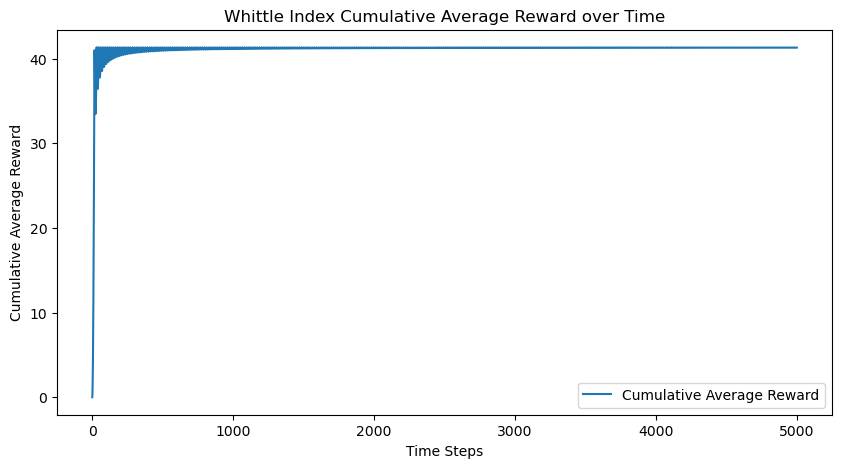

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('simulated_sensor_data.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
m_i = 2                               # Threshold for penalizing sending
num_nodes_to_poll = 20                # Number of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.1                             # Probability of transmission failure
gamma = 0.9                           # Discount factor for future rewards

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

# Initialize value function
V_mi = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize cumulative reward tracker
cumulative_reward = []
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

def calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i):
    # Calculate R_s as the age of incorrect information
    R_s = delta_t * d

    # Calculate V_mi_fail as the expected value when transmission fails
    V_mi_fail = d_t_plus_1 * (delta_t + 1)

    # V_mi_success remains 0 because success leads to a reset state
    V_mi_success = 0

    # Calculate Q-value for the pull action (a = 1)
    Q_value = -m_i + R_s + gamma * ((1 - pdr) * V_mi_success - pdr * V_mi_fail)
    return Q_value, R_s

def update_value_function(row, current_time_step):
    total_R_s = 0  # Initialize total reward for this time step
    for mote in V_mi:
        delta_t = current_time_step - last_update_times[mote]  # Calculate delta_t as the change in time

        # Access the previous state estimate
        previous_state = state_estimates[mote]

        # Predict the next state based on the previous state and delta_t
        predicted_state = predict_node_state(previous_state, delta_t)

        # Predict the measurement from the predicted state
        predicted_measurement = H @ predicted_state

        # Predict the future state and measurement for t + delta_t + 1
        future_state = predict_node_state(predicted_state, delta_t + 1)
        future_predicted_measurement = H @ future_state

        # Calculate the distance metric d (difference between predicted measurement and previous state)
        d = abs(predicted_measurement[0, 0] - previous_state[0, 0])

        # Calculate d_t_plus_1 (difference between future predicted measurement and current predicted measurement)
        d_t_plus_1 = abs(future_predicted_measurement[0, 0] - predicted_measurement[0, 0])

        # Calculate Q value with the specified penalty and obtain the reward
        Q_1, R_s = calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i)

        # Update value function based on the Q value
        V_mi[mote] = Q_1

        # Accumulate the reward for this time step
        total_R_s += R_s

    # Append the total reward for this time step to the cumulative reward tracker
    cumulative_reward.append(total_R_s)

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_whittle_simulation():
    valuable_sensor_data = []
    rewards = []

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Update the value function for all nodes and calculate total reward for the current time step
        update_value_function(row, current_time_step)

        nodes_by_value = sorted(V_mi.keys(), key=lambda mote: V_mi[mote], reverse=True)
        top_m_nodes = [mote for mote in nodes_by_value if V_mi[mote] > 0][:num_nodes_to_poll]
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        for mote in nodes_to_poll:
            previous_state = state_estimates[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)
            xp = A_delta @ previous_state
            z = np.array([[row[mote]]])
            K = np.zeros((2, 1))
            x_hat = xp + K @ (z - H @ xp)
            state_estimates[mote] = x_hat

            last_update_times[mote] = current_time_step

    return cumulative_reward

# Run the Whittle index simulation and collect rewards
whittle_rewards = run_whittle_simulation()

# Save cumulative rewards for Whittle index to CSV
pd.DataFrame(whittle_rewards, columns=["cumulative_reward"]).to_csv('cumulative_rewards_whittle.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Whittle index
cumulative_reward_array = np.cumsum(whittle_rewards)
cumulative_average_reward = cumulative_reward_array / (np.arange(len(cumulative_reward_array)) + 1)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward)), cumulative_average_reward, label='Cumulative Average Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Average Reward')
plt.title('Whittle Index Cumulative Average Reward over Time')
plt.legend()
plt.show()


Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 0.6963976954202826
Overall Average MSE: 7.566149329921953


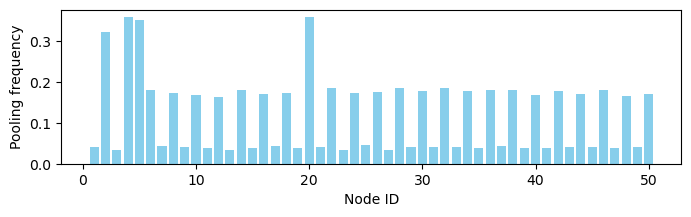

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('simulated_sensor_data.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 2                           # Sensitivity threshold for event detection
m_i = 2                               # Threshold for penalizing sending
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 5000           # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.1                             # Probability of transmission failure
gamma = 0.9                           # Discount factor for future rewards

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

# Initialize value function
V_mi = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize cumulative reward tracker
cumulative_reward = []

def calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i):
    # Calculate R_s as the age of incorrect information
    R_s = delta_t * d

    # Calculate V_mi_fail as the expected value when transmission fails
    V_mi_fail = d_t_plus_1 * (delta_t + 1)

    # V_mi_success remains 0 because success leads to a reset state
    V_mi_success = 0

    # Calculate Q-value for the pull action (a = 1)
    Q_value = -m_i + R_s + gamma * ((1 - pdr) * V_mi_success - pdr * V_mi_fail)
    return Q_value, R_s

def update_value_function(row, current_time_step):
    rewards = {}
    for mote in V_mi:
        delta_t = current_time_step - last_update_times[mote]  # Calculate delta_t as the change in time

        # Access the previous state estimate
        previous_state = state_estimates[mote]

        # Predict the next state based on the previous state and delta_t
        predicted_state = predict_node_state(previous_state, delta_t)

        # Predict the measurement from the predicted state
        predicted_measurement = H @ predicted_state

        # Predict the future state and measurement for t + delta_t + 1
        future_state = predict_node_state(predicted_state, delta_t + 1)
        future_predicted_measurement = H @ future_state

        # Calculate the distance metric d (difference between predicted measurement and previous state)
        d = abs(predicted_measurement[0, 0] - previous_state[0, 0])

        # Calculate d_t_plus_1 (difference between future predicted measurement and current predicted measurement)
        d_t_plus_1 = abs(future_predicted_measurement[0, 0] - predicted_measurement[0, 0])

        # Calculate Q value with the specified penalty and obtain the reward
        Q_1, R_s = calculate_Q_value(mote, delta_t, d, d_t_plus_1, m_i)

        # Update value function based on the Q value
        V_mi[mote] = Q_1

        # Store the reward for this mote
        rewards[mote] = R_s

    return rewards

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    mse_values = {f'mote{i}': [] for i in range(1, 51)}  # To track MSE values for each node

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Update the value function for all nodes and calculate rewards for each node
        rewards = update_value_function(row, current_time_step)

        nodes_by_value = sorted(V_mi.keys(), key=lambda mote: V_mi[mote], reverse=True)
        top_m_nodes = [mote for mote in nodes_by_value if V_mi[mote] > 0][:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        total_reward_for_round = 0
        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[row[mote]]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - row[mote])
            mse_values[mote].append(diff**2)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': row[mote],
                'time_elapsed': j
            })

            last_update_times[mote] = current_time_step

            # Accumulate reward for the pulled nodes
            if mote in top_m_nodes:
                total_reward_for_round += rewards[mote]

        # Append the total reward for the round to cumulative reward tracker
        cumulative_reward.append(total_reward_for_round)

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Pad the MSE lists to the same length
    max_length = max(len(v) for v in mse_values.values())
    for key in mse_values:
        mse_values[key].extend([None] * (max_length - len(mse_values[key])))

    mse_df = pd.DataFrame(mse_values)

    return valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
mse_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    mse_df_list.append(mse_df)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Calculate the overall average MSE
overall_mse = mse_df_list[0].mean().mean()
print(f"Overall Average MSE: {overall_mse}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Pooling frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()


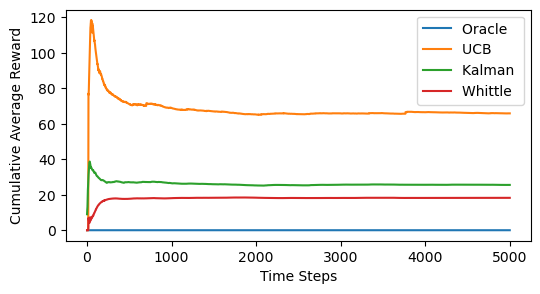

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load cumulative rewards from CSV files
cumulative_rewards_oracle = pd.read_csv('cumulative_rewards_oracle.csv')['cumulative_reward'].values
cumulative_rewards_ucb = pd.read_csv('cumulative_rewards_ucb.csv')['cumulative_reward'].values
cumulative_rewards_kalman = pd.read_csv('cumulative_rewards_kalman.csv')['cumulative_reward'].values
cumulative_rewards_whittle = pd.read_csv('cumulative_rewards_whittle.csv')['cumulative_reward'].values

# Calculate cumulative average rewards
cumulative_average_reward_oracle = np.cumsum(cumulative_rewards_oracle) / (np.arange(len(cumulative_rewards_oracle)) + 1)
cumulative_average_reward_ucb = np.cumsum(cumulative_rewards_ucb) / (np.arange(len(cumulative_rewards_ucb)) + 1)
cumulative_average_reward_kalman = np.cumsum(cumulative_rewards_kalman) / (np.arange(len(cumulative_rewards_kalman)) + 1)
cumulative_average_reward_whittle = np.cumsum(cumulative_rewards_whittle) / (np.arange(len(cumulative_rewards_whittle)) + 1)

# Plot cumulative average rewards over time for all techniques
plt.figure(figsize=(6, 3))
plt.plot(range(len(cumulative_average_reward_oracle)), cumulative_average_reward_oracle, label='Oracle ')
plt.plot(range(len(cumulative_average_reward_ucb)), cumulative_average_reward_ucb, label='UCB ')
plt.plot(range(len(cumulative_average_reward_kalman)), cumulative_average_reward_kalman, label='Kalman ')
plt.plot(range(len(cumulative_average_reward_whittle)), cumulative_average_reward_whittle, label='Whittle ')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Average Reward')
#plt.title('Cumulative Average Reward Comparison over Time')
plt.legend()
plt.show()


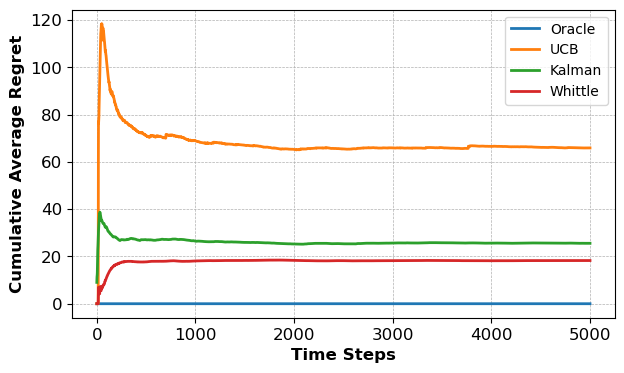

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load cumulative rewards from CSV files
cumulative_rewards_oracle = pd.read_csv('cumulative_rewards_oracle.csv')['cumulative_reward'].values
cumulative_rewards_ucb = pd.read_csv('cumulative_rewards_ucb.csv')['cumulative_reward'].values
cumulative_rewards_kalman = pd.read_csv('cumulative_rewards_kalman.csv')['cumulative_reward'].values
cumulative_rewards_whittle = pd.read_csv('cumulative_rewards_whittle.csv')['cumulative_reward'].values

# Calculate cumulative average rewards
cumulative_average_reward_oracle = np.cumsum(cumulative_rewards_oracle) / (np.arange(len(cumulative_rewards_oracle)) + 1)
cumulative_average_reward_ucb = np.cumsum(cumulative_rewards_ucb) / (np.arange(len(cumulative_rewards_ucb)) + 1)
cumulative_average_reward_kalman = np.cumsum(cumulative_rewards_kalman) / (np.arange(len(cumulative_rewards_kalman)) + 1)
cumulative_average_reward_whittle = np.cumsum(cumulative_rewards_whittle) / (np.arange(len(cumulative_rewards_whittle)) + 1)

# Plot cumulative average rewards over time for all techniques
plt.figure(figsize=(7, 4))
plt.plot(range(len(cumulative_average_reward_oracle)), cumulative_average_reward_oracle, label='Oracle', linewidth=2)
plt.plot(range(len(cumulative_average_reward_ucb)), cumulative_average_reward_ucb, label='UCB', linewidth=2)
plt.plot(range(len(cumulative_average_reward_kalman)), cumulative_average_reward_kalman, label='Kalman', linewidth=2)
plt.plot(range(len(cumulative_average_reward_whittle)), cumulative_average_reward_whittle, label='Whittle', linewidth=2)
plt.xlabel('Time Steps', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Average Regret', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()


# Inclusion of Pdr

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('synthetic_dataset_two.csv')

# Parameters
H = np.array([[1, 0, 0]])             # Measurement matrix for temperature (ignore PDR)
Q = np.array([[1e-5, 0, 0], [0, 1e-5, 0], [0, 0, 1e-4]])  # Process noise covariance (including PDR)
R = np.array([[0.5]])                 # Measurement noise covariance for temperature
epsilon = 0.3                         # Sensitivity threshold for event detection
theta = 0.5                           # Threshold for significant change
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
window_size = 10                      # Window size for sliding window PDR calculation

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t, 0], [0, 1, 0], [0, 0, 1]])  # PDR remains constant unless updated

def run_simulation(num_nodes_to_poll):
    # Initialize state estimates (temperature, temperature trend, PDR estimate)
    state_estimates = {f'mote{i}': np.array([[20], [0.01], [1.0]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((3, 3)) for i in range(1, 51)}  # Initialize to zeros
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    poll_history = {f'mote{i}': [] for i in range(1, 51)}  # History of the last N polls
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
        return A @ x_hat

    def update_pdr(mote):
        """Update the PDR based on the sliding window of recent polls."""
        if len(poll_history[mote]) > 0:
            return sum(poll_history[mote]) / len(poll_history[mote])
        else:
            return 1.0  # Default to 1.0 if no pulls have been made yet

    def select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes):
        covariance_traces = {mote: np.trace(P[mote]) for mote in state_estimates}
        sorted_motes_by_trace = sorted(covariance_traces, key=covariance_traces.get, reverse=True)
        top_nodes = set(sorted_motes_by_trace[:num_nodes_to_poll])
        return top_nodes | currently_polled_nodes

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        top_sensors = select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes)

        total_reward_for_round = 0
        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            
            A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Corrected section
            last_value = last_sensed_values[mote]
            diff = abs(measured_value - last_value)
            R_s = diff

            if R_s > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += R_s
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                # Simulate a successful transmission with the current PDR estimate
                success = 1 if np.random.rand() < state_estimates[mote][2, 0] else 0

                # Update poll history and PDR
                poll_history[mote].append(success)
                if len(poll_history[mote]) > window_size:
                    poll_history[mote].pop(0)  # Remove the oldest entry if the window is full
                
                # Update PDR in the state estimate
                state_estimates[mote][2, 0] = update_pdr(mote)

                valuable_sensor_data.append({
                    'index': current_time_step,
                    'selected_moteid': mote,
                    'temperature': measured_value,
                    'predicted_temperature': x_hat[0, 0],  # Still keep the predicted temperature for analysis
                    'pdr': state_estimates[mote][2, 0],   # Track PDR estimate
                    'time_elapsed': delta_t
                })

            currently_polled_nodes.add(mote)
            last_update_times[mote] = current_time_step

        cumulative_reward.append(total_reward_for_round)

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, cumulative_reward, valuable_sensor_df

# Running the simulation
results = {}
valuable_sensor_df_list = []
cumulative_rewards_kalman = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running Kalman simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, cumulative_reward, valuable_sensor_df = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    cumulative_rewards_kalman.append(cumulative_reward)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    print(f"Completed Kalman simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"Average MSE: {metrics['MSE']}")
    print(f"Average sensor lifetime (years): {metrics['Lifetime (years)']}")


Running Kalman simulation for 10 nodes to poll...
Completed Kalman simulation for 10 nodes to poll.
Nodes to poll: 10
Average MSE: 5.294880971875324
Average sensor lifetime (years): 2.2227108643000224


Running Whittle simulation for 10 nodes to poll...
Completed Whittle simulation for 10 nodes to poll.


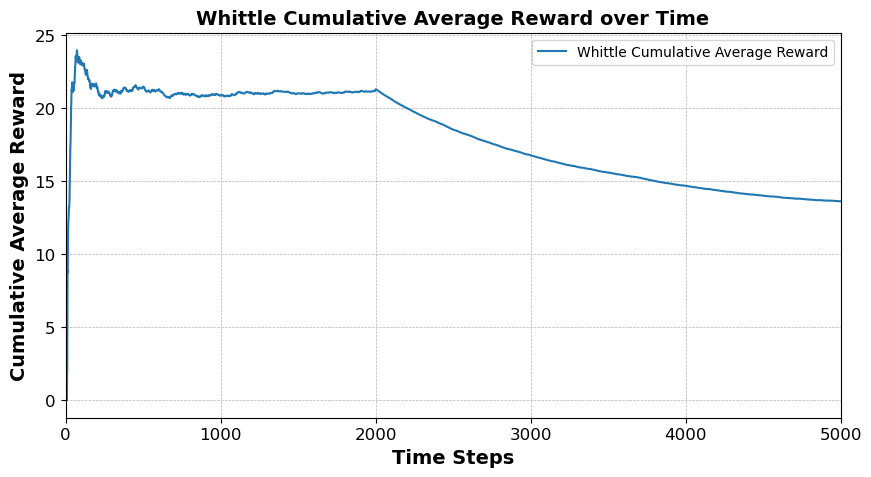

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
pivot_df = pd.read_csv('synthetic_dataset_two.csv')

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 0.3                         # Sensitivity threshold for event detection
theta = 0.5                           # Threshold for significant change
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
window_size = 10                      # Sliding window size for PDR calculation

# UCB parameters
alpha = 2  # Exploration parameter for UCB

# BanditArm class
class BanditArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        self.N = 0  # Number of samples collected so far

    def update(self, value):
        self.N += 1
        self.value_estimate = ((self.N - 1) * self.value_estimate + value) / self.N

def ucb(p_estimate, total_pulls, n):
    return p_estimate + np.sqrt(2 * np.log(total_pulls) / n) if n > 0 else float('inf')

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def update_pdr(mote, poll_history):
    """Update the PDR based on the sliding window of recent polls."""
    if len(poll_history[mote]) > 0:
        return sum(poll_history[mote]) / len(poll_history[mote])
    else:
        return 1.0  # Default to 1.0 if no pulls have occurred

def run_simulation(num_nodes_to_poll):
    # Initialize state estimates (temperature, temperature trend)
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    pdr_estimates = {f'mote{i}': 1.0 for i in range(1, 51)}  # Initialize PDR estimates to 1.0
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    bandit_arms = {f'mote{i}': BanditArm() for i in range(1, 51)}
    poll_history = {f'mote{i}': [] for i in range(1, 51)}  # Store success/failure history
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()  # Initialize previously_polled_nodes
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        total_pulls = sum(polled_count.values())
        expected_rewards = {mote: 0 for mote in state_estimates}  # Initialize expected rewards dictionary
        
        for mote in state_estimates:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                pdr = pdr_estimates[mote]  # Extract the PDR from the separate dictionary
                E_R_s =  -theta + 0.1 * delta_t + pdr * abs(predicted_value - current_value)

                if np.isnan(E_R_s):
                    E_R_s = 0  # Replace NaN expected rewards with zero
                expected_rewards[mote] = E_R_s
        
        # Update value estimates for all nodes
        for mote in expected_rewards:
            bandit_arms[mote].update(expected_rewards[mote])

        ucb_values = {
            mote: ucb(bandit_arms[mote].value_estimate, total_pulls, polled_count[mote])
            for mote in state_estimates
        }
        # Select top M nodes based on UCB scores
        nodes_by_ucb = sorted(ucb_values.keys(), key=lambda mote: ucb_values[mote], reverse=True)
        top_m_nodes = nodes_by_ucb[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            if expected_rewards[mote] > theta:
                nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        total_reward_for_round = 0
        for mote in nodes_to_poll:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            A_R_s = abs(last_sensed_values[mote] - measured_value)  # Calculate the actual reward
            if np.isnan(A_R_s):
                A_R_s = 0  # Replace NaN actual rewards with zero

            if A_R_s > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += A_R_s
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                # Simulate a successful transmission with the current PDR estimate
                success = 1 if np.random.rand() < pdr_estimates[mote] else 0

                # Update poll history and PDR
                poll_history[mote].append(success)
                if len(poll_history[mote]) > window_size:
                    poll_history[mote].pop(0)  # Remove the oldest entry if the window is full
                
                # Update PDR in the separate PDR estimate
                pdr_estimates[mote] = update_pdr(mote, poll_history)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'Temperature': measured_value,
                'predicted temperature': x_hat[0, 0],
                'time_elapsed': delta_t
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 2000:
                transmission_events_1[mote].append(current_time_step)
            elif 2000 <= current_time_step < 5000:
                transmission_events_2[mote].append(current_time_step)

        cumulative_reward.append(total_reward_for_round)
        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['Temperature'] - valuable_sensor_df['predicted temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    return average_mse, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2

# Running the simulation
results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
cumulative_rewards_whittle = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running Whittle simulation for {num_nodes_to_poll} nodes to poll...")
    mse, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2 = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse}
    cumulative_rewards_whittle.append(cumulative_reward)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    print(f"Completed Whittle simulation for {num_nodes_to_poll} nodes to poll.")

# Save cumulative rewards for Whittle to CSV
pd.DataFrame(cumulative_rewards_whittle[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_whittle.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Whittle
cumulative_reward_array_whittle = np.cumsum(cumulative_rewards_whittle[0])
cumulative_average_reward_whittle = cumulative_reward_array_whittle / (np.arange(len(cumulative_reward_array_whittle)) + 1)

# Plot cumulative average reward over time for Whittle
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_whittle)), cumulative_average_reward_whittle, label='Whittle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Whittle Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset
plt.show()
